In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.getOrCreate()

In [94]:
spark

In [48]:
df = spark.read.csv("HousingData.csv", inferSchema=True , header=True) 

In [7]:
df.cache()
df.printSchema()

root
 |-- CRIM: string (nullable = true)
 |-- ZN: string (nullable = true)
 |-- INDUS: string (nullable = true)
 |-- CHAS: string (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: string (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: string (nullable = true)
 |-- MEDV: double (nullable = true)



In [49]:
from pyspark.sql.functions import col
df = df.select(*(col(c).cast('double').alias(c) for c in df.columns))

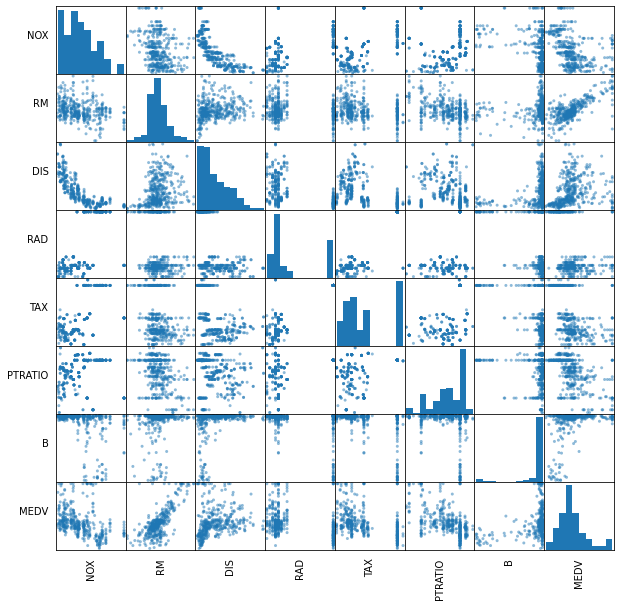

In [8]:
import pandas as pd
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [12]:
import six
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MEDV for ", i, df.stat.corr('MEDV',i))

Correlation to MEDV for  CRIM -0.3841205023310656
Correlation to MEDV for  ZN 0.3622924741501993
Correlation to MEDV for  INDUS -0.4413714572776502
Correlation to MEDV for  CHAS 0.18384443985872262
Correlation to MEDV for  NOX -0.42732077593883866
Correlation to MEDV for  RM 0.6953599371216598
Correlation to MEDV for  AGE -0.3566992474940591
Correlation to MEDV for  DIS 0.24992873876328828
Correlation to MEDV for  RAD -0.38162623156694825
Correlation to MEDV for  TAX -0.46853593529288873
Correlation to MEDV for  PTRATIO -0.5077867038903069
Correlation to MEDV for  B 0.33346082268133653
Correlation to MEDV for  LSTAT -0.6954050690486553
Correlation to MEDV for  MEDV 1.0


In [50]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

def transData(data):
 return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [51]:
transformed= transData(df)
transformed.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.00632,18.0,2.3...| 24.0|
|[0.02731,0.0,7.07...| 21.6|
|[0.02729,0.0,7.07...| 34.7|
|[0.03237,0.0,2.18...| 33.4|
|[0.06905,0.0,2.18...| 36.2|
+--------------------+-----+
only showing top 5 rows



In [52]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)

In [43]:
featureIndexer

VectorIndexerModel: uid=VectorIndexer_df664c04b21a, numFeatures=13, handleInvalid=error

In [53]:
data.show(5,True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|[0.00632,18.0,2.3...| 24.0|[0.00632,18.0,2.3...|
|[0.02731,0.0,7.07...| 21.6|[0.02731,0.0,7.07...|
|[0.02729,0.0,7.07...| 34.7|[0.02729,0.0,7.07...|
|[0.03237,0.0,2.18...| 33.4|[0.03237,0.0,2.18...|
|[0.06905,0.0,2.18...| 36.2|[0.06905,0.0,2.18...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [64]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

In [65]:
trainingData.show(5)
testData.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.00632,18.0,2.3...| 24.0|
|[0.00906,90.0,2.9...| 32.2|
|[0.01311,90.0,1.2...| 35.4|
|[0.01381,80.0,0.4...| 50.0|
|[0.01501,80.0,2.0...| 24.5|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.01096,55.0,2.2...| 22.0|
|[0.01301,35.0,1.5...| 32.7|
|[0.0136,75.0,4.0,...| 18.9|
|[0.01432,100.0,1....| 31.6|
|[0.01439,60.0,2.9...| 29.1|
+--------------------+-----+
only showing top 5 rows



In [70]:
from pyspark.ml.regression import DecisionTreeRegressor

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="indexedFeatures")

In [71]:
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, dt])

model = pipeline.fit(trainingData)

In [72]:
# Make predictions.
predictions = model.transform(testData)

In [74]:
# Select example rows to display.
predictions.select("features","label","prediction").show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.01096,55.0,2.2...| 22.0|21.396842105263158|
|[0.01301,35.0,1.5...| 32.7|33.290000000000006|
|[0.0136,75.0,4.0,...| 18.9|15.286206896551725|
|[0.01432,100.0,1....| 31.6| 29.91111111111111|
|[0.01439,60.0,2.9...| 29.1| 29.91111111111111|
+--------------------+-----+------------------+
only showing top 5 rows



In [75]:
#Evaluuation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label",
                                predictionCol="prediction",
                                metricName="rmse")

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.60152


In [76]:
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {0}'.format(r2_score))

r2_score: 0.5833056087733836


In [77]:
model.stages[1].featureImportances

SparseVector(13, {0: 0.0444, 1: 0.0033, 4: 0.0319, 5: 0.6361, 6: 0.0036, 7: 0.0705, 8: 0.0072, 9: 0.0116, 10: 0.0085, 12: 0.183})

Fit RandomForest Regression Model

In [78]:

from pyspark.ml.regression import RandomForestRegressor

# Define RandomForest algorithm
rf = RandomForestRegressor()

In [79]:
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])
model = pipeline.fit(trainingData)

In [80]:
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("features","label", "prediction").show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.01096,55.0,2.2...| 22.0|24.094151948996696|
|[0.01301,35.0,1.5...| 32.7|32.562444157514705|
|[0.0136,75.0,4.0,...| 18.9| 21.26280620041672|
|[0.01432,100.0,1....| 31.6| 31.36705663205654|
|[0.01439,60.0,2.9...| 29.1|28.455985461515837|
+--------------------+-----+------------------+
only showing top 5 rows



In [81]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.81658


In [82]:
import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {:4.3f}'.format(r2_score))

r2_score: 0.583


Gradient Boosting Regression

In [83]:
# Import GradientBoostingRegression class
from pyspark.ml.regression import GBTRegressor

# Define GBT algorithm
rf = GBTRegressor()

In [84]:
# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, rf])
model = pipeline.fit(trainingData)

In [85]:
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("features","label", "prediction").show(5)

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[0.01096,55.0,2.2...| 22.0|21.828800010531822|
|[0.01301,35.0,1.5...| 32.7|32.139937995010605|
|[0.0136,75.0,4.0,...| 18.9| 15.88457411552679|
|[0.01432,100.0,1....| 31.6|28.071664176725527|
|[0.01439,60.0,2.9...| 29.1| 33.84821626232712|
+--------------------+-----+------------------+
only showing top 5 rows



In [86]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.49252


In [87]:
import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {:4.3f}'.format(r2_score))

r2_score: 0.583
